# Build coding models
Sam Tomioka

This is a POC of using FastText word embedding with subwording built on MedDRA dictionaries from Version 4.0-22.0, and Sunovion's 4 ISS ADAE and ADMH as an embedding layer of the deep neural network for MedDRA coding.

## 1. Initialize

In [ ]:
!pip install spacy sas7bdat gensim

In [ ]:
!python -m spacy download en_core_web_sm

In [42]:
import pandas as pd
import sagemaker
from sagemaker import get_execution_role
import boto3
import os
import pickle
import json
from sas7bdat import SAS7BDAT


#To create embedding layer
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

import numpy as np
import tensorflow as tf
from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize
from tensorflow.python.ops import math_ops

# to create attention models
import keras.backend as K
import numpy as np
from keras.layers import concatenate, Bidirectional, Dropout, MaxPooling1D, Conv1D
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *
from keras.optimizers import Adam
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

# plots
import matplotlib.pyplot as plt

%matplotlib inline
#Config
sess = sagemaker.Session()
s3 = boto3.resource('s3')
role = get_execution_role()
print(role) # This is the role that SageMaker would use to leverage AWS resources (S3, CloudWatch)

bucket='snvn-sagemaker-1' #data bucket
print(bucket)
prefix = 'mldata/Sam/blazingtext/subwords' #Replace with the prefix under which you want to store the data if needed
modelkey100D=os.path.join(prefix, 'output','AdverseEventsBTSubwordModel','output','model.tar.gz')
modelkey500D=os.path.join(prefix, 'output','AdverseEventsBTSubwordModel500D','output','model.tar.gz')

arn:aws:iam::497587121589:role/service-role/AmazonSageMaker-ExecutionRole-20181113T220278
snvn-sagemaker-1


## 2. Def

In [2]:
class callback_(tf.keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs={}):
        if (logs.get('val_acc')>0.95):
            print('Reached 95% validation accuracy so cancelling training')
            self.model.stop_training=True


In [3]:
def load_data_sas(file, term, pt, soc):
    '''load sas7bdat, returns standard coding file
    param:
    term: --TERM
    pt: --DECOD
    soc: --BODSYS
    '''
    tmp=SAS7BDAT('dict/'+file+'.sas7bdat').to_data_frame()
    tmp=tmp[[term, pt, soc]]
    return tmp.rename(index=str, columns={term: 'TERM', pt: 'DECOD', soc: 'SOC'})

def load_data_xpt(file, term, pt, soc):
    '''load xpt, returns standard coding file
    param:
    term: --TERM
    pt: --DECOD
    soc: --BODSYS
    '''
    tmp=pd.read_sas('dict/'+file+'.xpt',encoding='latin') 
    tmp=tmp[[term, pt, soc]]
    return tmp.rename(index=str, columns={term: 'TERM', pt: 'DECOD', soc: 'SOC'})

def get_wdvec(text):
    '''get word vectors'''
    return wdvec.get_vector(text)

def dfClean(df):
    '''clean up df
    1. remove punctuations
    2. remove empty spaces to np.NAN
    '''
    df=df.applymap(str.lower)
    df.replace(r'[^\w\s]+',' ', inplace=True, regex=True)
    df.replace('', np.NaN, inplace=True)

    return df

def dataprep(df, stopwords = spacy.lang.en.stop_words.STOP_WORDS):
    df=dfClean(df)
    df['TERM'].apply(lambda x: [w for w in str(x).split() if w  not in stopwords])
    dfs=df.dropna(how='all')
    dfs.reset_index(inplace=True, drop=True)
    X=dfs['TERM']
    Y=dfs['DECOD']
    #X=pd.concat([dfs['TERM'], dfs['TERM']])
    #Y=pd.concat([dfs['DECOD'], dfs['DECOD']])
    X_lst =[w.split() for w in X]
    #X_lst=dfs['TERM']
    return X, Y, X_lst

#f1
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    print(K.get_value(precision))
    print(K.get_value(recall))
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def emdlayer(window, textlst, dim):
    '''generate embedding layer
    random normal distribution from 0 to 0.01.
    '''

    v_tmp=[np.array([get_wdvec(i) 
                     if i in wdvec.vocab 
                     else (np.random.randn(dim,)*0.01).astype('float32') for i in record[0:window]])
           for record in textlst]
    vec = np.array([np.concatenate((v_tmp[i],
                                    (np.random.randn(window-v_tmp[i].shape[0], dim)*0.01).astype('float32')),
                                   axis=0)
        for i in range(len(textlst))])
    return vec



def plotresult(hist, title, outputfile):
    acc = hist.history['acc']
    val_acc = hist.history['val_acc']

    epochs = len(acc)
    plt.plot(range(epochs), acc, marker='.', label='acc')
    plt.plot(range(epochs), val_acc, marker='.', label='val_acc')
    plt.legend(loc='best')
    plt.grid()
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.title('Training/Validation: '+ title)
    plt.savefig('images/'+outputfile)
    plt.show()


## Load data

In [4]:
#meddralst=['meddra40','meddra50','meddra60','meddra70','meddra81',
#           'meddra90','meddra100','meddra110','meddra111','meddra120',
#          'meddra130','meddra140','meddra150','meddra160',
#           'meddra170','meddra180','meddra190','meddra200',
#          'meddra210','meddra220']
meddralst=['meddra220']        
meddra=pd.DataFrame()
for i in meddralst:
    tmp=load_data_sas(i, 'lltname','ptname','socname')
    meddra=pd.concat([meddra,tmp])   

stopwords = spacy.lang.en.stop_words.STOP_WORDS
meddra['TERM']=meddra['TERM'].apply(lambda x: [w for w in str(x).split() if w  not in stopwords])

training data

In [5]:
ae=load_data_sas('issae', 'AETERM','AEDECOD','AEBODSYS')
mh=load_data_sas('issmh', 'MHTERM','MHDECOD','MHBODSYS')
daso_adae=load_data_sas('daso_adae', 'AETERM','AEDECOD','AEBODSYS')
daso_admh=load_data_sas('daso_admh', 'MHTERM','MHDECOD','MHBODSYS')
sun_adae=load_data_sas('sun_adae', 'AETERM','AEDECOD','AEBODSYS')
sun_admh=load_data_sas('sun_admh','MHTERM','MHDECOD','MHBODSYS')
apl_adae=load_data_xpt('apl_adae', 'AETERM','AEDECOD','AEBODSYS')
apl_admh=load_data_xpt('apl_admh', 'MHTERM','MHDECOD','MHBODSYS')
ae360201=load_data_sas('ae360201', 'AETERM','AEDECOD','AEBODSYS')
mh360201=load_data_sas('mh360201','MHTERM','MHDECOD','MHBODSYS')

In [6]:
ae360202=load_data_sas('ae360202', 'AETERM','AEDECOD','AEBODSYS')

We have 30211 classes total if meddra is added. First, let's exclude MedDRA. term=pd.concat([meddra,mh, ae,daso_adae,daso_admh,sun_adae,sun_admh,apl_adae,apl_admh])

#### Training Data

In [7]:
term=pd.concat([meddra,mh, ae,daso_adae,daso_admh,sun_adae,sun_admh,apl_adae,apl_admh,ae360201,mh360201])
x_train, Y_train, X_lst= dataprep(term)

In [8]:
x_train.shape, len(Y_train), len(X_lst)

((259954,), 259954, 259954)

In [9]:
print('Classes: ',len(set(Y_train)), 'Max cnt of w: ', max([len(w) for w in X_lst]))

Classes:  23908 Max cnt of w:  34


We have about 4000 classes total based on our data and total of 30178  with MedDRA. First smaller model is created. Later a larger model will be created.

#### Test Data

In [10]:
_, Y_test,_= dataprep(ae360202)
ae360202=dfClean(ae360202)
for pt in [i for i in set(ae360202['DECOD'].tolist()) if i not in  set(Y_train.tolist())]:
    ae360202=ae360202[ae360202['DECOD'] != pt]
ae360202.reset_index(drop=True, inplace=True)

In [11]:
x_test, Y_test, X_testlst= dataprep(ae360202)

#### Class encoder/decoder

In [12]:
encoder = {}
for i, pt in enumerate(set(Y_train)):
    encoder.update({pt: i})
    i = i + 1
decoder = dict([(pt, i) for i, pt in encoder.items()])

outfile = open(os.path.join('models', 'ptcoder.pkl'),'wb')
pickle.dump(encoder,outfile)
outfile.close()
outfile = open(os.path.join('models', 'ptdecoder.pkl'),'wb')
pickle.dump(decoder,outfile)
outfile.close()

#### class

In [13]:
y_train =np.array( [[encoder[i]] for i in Y_train])
y_test = np.array([[encoder[i]] for i in Y_test])

#### Check classes in training and test

In [14]:
#print("extra in training:   ",[i for i in set(y_train) if i not in  set(y_test)])
print("extra in test: ",[i for i in set(ae360202['DECOD'].tolist()) if i not in  set(Y_train.tolist())])

extra in test:  []


In [15]:
bucket='snvn-sagemaker-1' #data bucket
print(bucket)
prefix = 'mldata/Sam/project/meddracoding'
term.to_csv('training.txt', index=False)

snvn-sagemaker-1


In [16]:
sess.upload_data(path='training.txt', bucket=bucket, key_prefix=prefix)

's3://snvn-sagemaker-1/mldata/Sam/project/meddracoding/training.txt'

## Prep for local run of an endpoint
Instead of deploying the model on aws, first try this on local. The trained FastText with subwording on 4,396,262 records of adverse events is used here. 


In [17]:
print(modelkey100D)
s3.Bucket(bucket).download_file(modelkey100D, 'models/100d/modelkey100D.tar.gz')
!tar -xvzf models/100d/modelkey100D.tar.gz -C models/100d

mldata/Sam/blazingtext/subwords/output/AdverseEventsBTSubwordModel/output/model.tar.gz
eval.json
vectors.bin
vectors.txt


In [22]:
print(modelkey500D)
s3.Bucket(bucket).download_file(modelkey500D, 'models/500d/modelkey500D.tar.gz')
!tar -xvzf models/500d/modelkey500D.tar.gz -C models/500d

In [18]:
wdvec = KeyedVectors.load_word2vec_format('models/100d/vectors.txt', binary=False, unicode_errors='ignore')

In [19]:
#wdvec = KeyedVectors.load_word2vec_format('models/500d/vectors.txt', binary=False, unicode_errors='ignore')

#test
t=get_wdvec('leg')
t.shape
wdvec.most_similar_cosmul(positive=['leg', 'limb'], negative=['hand'])

check the max length of the sentences after coverting it to uni-gram model and removal of stopwords

In [19]:
N=len(max(X_lst,key=len))
N

34

check the distribution of sizes

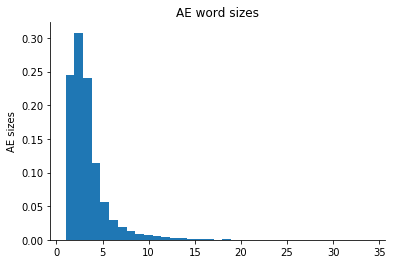

In [21]:
aesize=[len(i) for i in X_lst]
fig = plt.figure() 
ax = plt.axes() 

plt.style.use('seaborn-whitegrid')
plt.title('AE word sizes')
plt.hist(aesize, density=True, bins=35)
plt.ylabel('AE sizes')
ax.grid(False)
frameon=False
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('images/ae_size.png')

Build an embedding layer 


set window size to 7

### LSTM with attention

In [20]:
callbacks=callback_()

In [21]:
CLASSES=len(set(Y_train))
WINDOWS_Size=9

In [ ]:
def embedding_layer(BTSMDIM):
    if BTSMDIM==100:
        X=emdlayer(WINDOWS_Size, X_lst, 100)
        Xtest=emdlayer(WINDOWS_Size, X_testlst, 100)
        INPUT_DIM = X.shape[2]
        SINGLE_ATTENTION_VECTOR = False
    if BTSMDIM==500:
        X=emdlayer(WINDOWS_Size, X_lst, 500)
        Xtest=emdlayer(WINDOWS_Size, X_testlst, 500)
        INPUT_DIM = X.shape[2]
        SINGLE_ATTENTION_VECTOR = False

In [23]:
X.shape, y_train.shape, Xtest.shape, y_test.shape

((259954, 9, 100), (259954, 1), (276, 9, 100), (276, 1))

In [25]:
%%time
embedding_layer(500)

23908

134408 samples, 7 time steps, and 100 dimentions

In [60]:
def get_activations(model, inputs, print_shape_only=False, layer_name=None):

    print('----- activations -----')
    activations = []
    inp = model.input
    if layer_name is None:
        outputs = [layer.output for layer in model.layers]
    else:
        outputs = [layer.output for layer in model.layers if layer.name == layer_name]  # all layer outputs
    funcs = [K.function([inp] + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions
    layer_outputs = [func([inputs, 1.])[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        if print_shape_only:
            print(layer_activations.shape)
        else:
            print(layer_activations)
    return activations

def attention_3d_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Reshape((input_dim, WINDOWS_Size))(a) # this line is not useful. It's just to know which dimension is what.
    a = Dense(WINDOWS_Size, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    
    output_attention_mul = concatenate([inputs, a_probs], name='attention_mul')
    return output_attention_mul



def model_attention_applied_after_lstm():
    inputs = Input(shape=(WINDOWS_Size, INPUT_DIM,))
    lstm_units1 = 256
    lstm_out = LSTM(lstm_units1, return_sequences=True, recurrent_regularizer=regularizers.l2(0.01))(inputs)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = Flatten()(attention_mul)
    output = Dense(CLASSES, activation='softmax')(attention_mul)
    model = Model(input=[inputs], output=output)
    return model

def model_attention_applied_after_lstmv2():
    inputs = Input(shape=(WINDOWS_Size, INPUT_DIM,))

    lstm_out = LSTM(512, return_sequences=True, recurrent_regularizer=regularizers.l2(0.01))(inputs)
    lstm_out = LSTM(512, return_sequences=True, recurrent_regularizer=regularizers.l2(0.01))(lstm_out)
    dnn_out=Dense(256, activation=tf.nn.relu,kernel_regularizer=regularizers.l2(0.01))(lstm_out)
    attention_mul = attention_3d_block(dnn_out)
    attention_mul = Flatten()(attention_mul)
    output = Dense(CLASSES, activation='softmax')(attention_mul)
    model = Model(input=[inputs], output=output)
    return model


def model_attention_applied_after_bilstm():
    inputs = Input(shape=(WINDOWS_Size, INPUT_DIM,))
    drop=Dropout(0.2)(inputs)
    lstm_units1 = 256
    lstm_units2= 128
    #apply regularization to recurrent connections on each LSTM unit
    lstm_out = Bidirectional(LSTM(lstm_units1, activation='tanh',recurrent_regularizer=regularizers.l2(0.01),return_sequences=True))(drop)
    lstm_out = Bidirectional(LSTM(lstm_units2, activation='tanh',recurrent_regularizer=regularizers.l2(0.01), return_sequences=True))(lstm_out)
    dnn_out=Dense(128, activation=tf.nn.relu,kernel_regularizer=regularizers.l2(0.01))(lstm_out)
    attention_mul = attention_3d_block(dnn_out)
    attention_mul = Flatten()(attention_mul)
    
    #output = Dense(1, activation='sigmoid')(attention_mul)
    output = Dense(CLASSES, activation='softmax')(attention_mul)
    model = Model(input=[inputs], output=output)
    return model

def model_attention_applied_after_bilstm_ver2():
    inputs = Input(shape=(WINDOWS_Size, INPUT_DIM,))
    lstm_units1 = 512
    lstm_units2= 256
    #apply regularization to recurrent connections on each LSTM unit
    lstm_out = Bidirectional(LSTM(lstm_units1, activation='tanh',recurrent_regularizer=regularizers.l2(0.01),return_sequences=True))(inputs)
    lstm_out = Bidirectional(LSTM(lstm_units2, activation='tanh',recurrent_regularizer=regularizers.l2(0.01), return_sequences=True))(lstm_out)
    dnn_out=Dense(512, activation=tf.nn.relu,kernel_regularizer=regularizers.l2(0.01))(lstm_out)
    attention_mul = attention_3d_block(dnn_out)
    attention_mul = Flatten()(attention_mul)
    
    #output = Dense(1, activation='sigmoid')(attention_mul)
    output = Dense(CLASSES, activation='softmax')(attention_mul)
    model = Model(input=[inputs], output=output)
    return model

def model_conv():
    inputs = Input(shape=(WINDOWS_Size, INPUT_DIM,))

    conv_0 = Conv1D(64, 7,activation='relu',kernel_regularizer=regularizers.l2(0.01))(inputs)
    conv_1 = Conv1D(64, 5,activation='relu',kernel_regularizer=regularizers.l2(0.01))(inputs)
    conv_2 = Conv1D(64, 3,activation='relu',kernel_regularizer=regularizers.l2(0.01))(inputs)

    maxpool_0 = MaxPooling1D(pool_size=2)(conv_0)
    maxpool_1 = MaxPooling1D(pool_size=2)(conv_1)
    maxpool_2 = MaxPooling1D(pool_size=2)(conv_2)

    merged_tensor = concatenate([maxpool_0, maxpool_1, maxpool_2], axis=1)
    lstm_out = Bidirectional(LSTM(256, activation='tanh',recurrent_regularizer=regularizers.l2(0.01),return_sequences=True))(merged_tensor)
    merged_tensor = Flatten()(lstm_out)
    dnn_out=Dense(128, activation=tf.nn.relu)(merged_tensor)
    output = Dense(CLASSES, activation='softmax')(merged_tensor)
    model = Model(input=[inputs], output=output)
    return model

def model_conv_2():
    inputs = Input(shape=(WINDOWS_Size, INPUT_DIM,))
    attention_mul = attention_3d_block(inputs)
    conv_0 = Conv1D(64, 7,activation='relu',kernel_regularizer=regularizers.l2(0.01))(attention_mul)
    conv_0=Dropout(0.2)(conv_0)
    conv_1 = Conv1D(64, 5,activation='relu',kernel_regularizer=regularizers.l2(0.01))(attention_mul)
    conv_1=Dropout(0.2)(conv_1)
    conv_2 = Conv1D(64, 3,activation='relu',kernel_regularizer=regularizers.l2(0.01))(attention_mul)
    conv_2=Dropout(0.2)(conv_2)
    
    maxpool_0 = MaxPooling1D(pool_size=2)(conv_0)
    maxpool_1 = MaxPooling1D(pool_size=2)(conv_1)
    maxpool_2 = MaxPooling1D(pool_size=2)(conv_2)

    conc_tensor_0 = concatenate([maxpool_0, maxpool_1], axis=1)
    conc_tensor_1 = concatenate([maxpool_1, maxpool_2], axis=1)
    conc_tensor_2 = concatenate([maxpool_0, maxpool_2], axis=1)
    
    conc_tensor_0 = Flatten()(conc_tensor_0)
    conc_tensor_1 = Flatten()(conc_tensor_1)
    conc_tensor_2 = Flatten()(conc_tensor_2)
    
    dnn_out_1=Dense(256, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(0.01))(conc_tensor_0)
    dnn_out_2=Dense(256, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(0.01))(conc_tensor_1)    
    dnn_out_3=Dense(256, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(0.01))(conc_tensor_2)    

    conc_dnn_out=concatenate([dnn_out_1, dnn_out_2,dnn_out_3], axis=1)
    dnn_out_4=Dense(128, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(0.01))(conc_dnn_out)  
    dnn_out_5=Dense(128, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(0.01))(dnn_out_4) 
    dnn_out_6=Dense(128, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(0.01))(dnn_out_5) 
    output = Dense(CLASSES, activation='softmax')(dnn_out_6)
    model = Model(input=[inputs], output=output)
    return model


def model_attention_applied_before_bilstm():
    inputs = Input(shape=(WINDOWS_Size, INPUT_DIM,))
    attention_mul = attention_3d_block(inputs)
    lstm_units1 = 256
    lstm_units2= 128
    lstm_out = Bidirectional(LSTM(lstm_units1, return_sequences=True))(attention_mul)
    lstm_out = Bidirectional(LSTM(lstm_units2, return_sequences=False))(lstm_out)
    dnn_out=Dense(128, activation=tf.nn.relu)(lstm_out)
    output = Dense(CLASSES, activation='softmax')(dnn_out)
    model = Model(input=[inputs], output=output)
    return model

def model_attention_applied_before_lstmv():
    inputs = Input(shape=(WINDOWS_Size, INPUT_DIM,))
    attention_mul = attention_3d_block(inputs)
    lstm_units1 = 256
    lstm_units2= 128
    lstm_out = LSTM(lstm_units1, return_sequences=True, recurrent_regularizer=regularizers.l2(0.01))(attention_mul)

    lstm_out = Flatten()(lstm_out)
    dnn_out=Dense(128, activation=tf.nn.relu)(lstm_out)
    output = Dense(CLASSES, activation='softmax')(dnn_out)
    model = Model(input=[inputs], output=output)
    return model

## model_attention_applied_after_bilstm

In [29]:
m0 = model_attention_applied_after_lstm()

m0.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
m0.summary()

h0=m0.fit([X], y_train, epochs=30, batch_size=64, validation_split=0.2, callbacks=[callbacks])

Instructions for updating:
Colocations handled automatically by placer.
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:42: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 9, 500)       0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 9, 256)       775168      input_1[0][0]                    
__________________________________________________________________________________________________
permute_1 (Permute)             (None, 256, 9)       0           lstm_1[0][0]                     
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 256, 9)       0           permute_1[0][0]                  
__________________________________________________________________________________________________
dense_1 (D

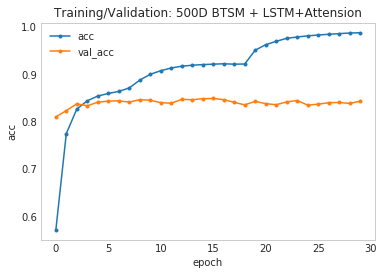

In [87]:


plotresult(h0, '500D BTSM + LSTM+Attension', 'm0-model_attention_applied_after_bilstm.png')   

In [33]:
score = m0.evaluate(Xtest, y_test, verbose=0)
print("loss/acc:", score)

loss/acc: [0.6650197132342104, 0.9166666675305021]


In [34]:
y_p = m0.predict(Xtest)

####obtain PT
y_pred = [decoder[i] for i in y_p.argmax(axis=1)]
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test.tolist(), y_pred)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 5]])

In [36]:
from sklearn.metrics import classification_report,precision_recall_fscore_support

print(classification_report(np.array(Y_test), np.array(y_pred)))
precision_micro, recall_micro , fbeta_micro, support_micro=precision_recall_fscore_support(np.array(Y_test), np.array(y_pred), average='micro')
precision_macro, recall_macro , fbeta_macro, support_macro=precision_recall_fscore_support(np.array(Y_test), np.array(y_pred), average='macro')
precision_w, recall_w , fbeta_w, support_w=precision_recall_fscore_support(np.array(Y_test), np.array(y_pred), average='weighted')
print ('Micro precision/recall/F1:', precision_micro,'/', recall_micro,'/',fbeta_micro)
print ('Macro precision/recall/F1:',       precision_macro, recall_macro,'/',fbeta_macro)
print ('Weighted precision/recall/F1:','/',       precision_w,'/', recall_w,'/',fbeta_w)

                                                precision    recall  f1-score   support

                          abdominal pain upper       0.00      0.00      0.00         0
                       acute myeloid leukaemia       0.00      0.00      0.00         0
                               acute psychosis       1.00      1.00      1.00         1
                                     agitation       1.00      1.00      1.00         4
                                     akathisia       1.00      1.00      1.00         1
            alanine aminotransferase increased       1.00      1.00      1.00         3
                                       anaemia       1.00      1.00      1.00         1
                               angina pectoris       1.00      1.00      1.00         1
                                 anisometropia       1.00      1.00      1.00         1
                                      anorexia       0.00      0.00      0.00         0
                               

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## Model 1

In [47]:
m1 = model_attention_applied_after_lstmv2()
m1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
m1.summary()

hbilstmattn=m1.fit([X], y_train, epochs=30, batch_size=64, validation_split=0.2, callbacks=[callbacks])

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:55: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 9, 500)       0                                            
__________________________________________________________________________________________________
lstm_12 (LSTM)                  (None, 9, 512)       2074624     input_7[0][0]                    
__________________________________________________________________________________________________
lstm_13 (LSTM)                  (None, 9, 512)       2099200     lstm_12[0][0]                    
__________________________________________________________________________________________________
dense_18 (Dense)                (None, 9, 256)       131328      lstm_13[0][0]                    
__________________________________________________________________________________________________
permute_7 

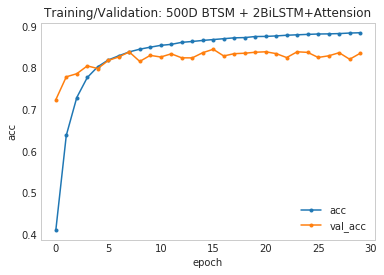

In [88]:
   
plotresult(hbilstmattn, '500D BTSM + 2BiLSTM+Attension', 'm1-model_attention_applied_after_bilstm.png')    

#### Prediction and eval

In [53]:
score = m1.evaluate(Xtest, y_test, verbose=0)
print("loss/acc:", score)

loss/acc: [0.8889142914094786, 0.9275362336117289]


#### Prediction

In [54]:
y_p = m1.predict(Xtest)

####obtain PT
y_pred = [decoder[i] for i in y_p.argmax(axis=1)]

In [55]:
#np.array(Y_test)

In [56]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test.tolist(), y_pred)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 4, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 5]])

In [57]:
#obtain indices
y_pred_i=np.array([[encoder[i]] for i in y_pred])

#obtain F1
tensor_true, tensor_pred = K.variable(y_test), K.variable(y_pred_i)
f1score = K.get_value(f1(tensor_true, tensor_pred))
f1score

1.0
1.0


1.0

In [58]:
from sklearn.metrics import classification_report,precision_recall_fscore_support

print(classification_report(np.array(Y_test), np.array(y_pred)))
precision_micro, recall_micro , fbeta_micro, support_micro=precision_recall_fscore_support(np.array(Y_test), np.array(y_pred), average='micro')
precision_macro, recall_macro , fbeta_macro, support_macro=precision_recall_fscore_support(np.array(Y_test), np.array(y_pred), average='macro')
precision_w, recall_w , fbeta_w, support_w=precision_recall_fscore_support(np.array(Y_test), np.array(y_pred), average='weighted')

                                           precision    recall  f1-score   support

                  acute myeloid leukaemia       0.00      0.00      0.00         0
                          acute psychosis       1.00      1.00      1.00         1
                                agitation       1.00      1.00      1.00         4
                                akathisia       1.00      1.00      1.00         1
       alanine aminotransferase increased       1.00      1.00      1.00         3
                                  anaemia       1.00      1.00      1.00         1
                          angina pectoris       1.00      1.00      1.00         1
                            anisometropia       1.00      1.00      1.00         1
                                 anorexia       0.00      0.00      0.00         0
                                  anxiety       1.00      1.00      1.00        39
                           arthropod bite       1.00      1.00      1.00         1
   

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [59]:
print ('Micro precision/recall/F1:', precision_micro,'/', recall_micro,'/',fbeta_micro)
print ('Macro precision/recall/F1:',       precision_macro, recall_macro,'/',fbeta_macro)
print ('Weighted precision/recall/F1:','/',       precision_w,'/', recall_w,'/',fbeta_w)

Micro precision/recall/F1: 0.927536231884058 / 0.927536231884058 / 0.927536231884058
Macro precision/recall/F1: 0.7366961020426367 0.7207920792079208 / 0.7251555198032793
Weighted precision/recall/F1: / 0.9371752186969579 / 0.927536231884058 / 0.9294170646792281


## model_attention_applied_before_lstmv

In [67]:


m2 = model_attention_applied_before_lstmv()
m2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
m2.summary()

hattenlstm=m2.fit([X], y_train, epochs=30, batch_size=64, validation_split=0.2, callbacks=[callbacks])

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 9, 500)       0                                            
__________________________________________________________________________________________________
permute_11 (Permute)            (None, 500, 9)       0           input_11[0][0]                   
__________________________________________________________________________________________________
reshape_11 (Reshape)            (None, 500, 9)       0           permute_11[0][0]                 
__________________________________________________________________________________________________
dense_29 (Dense)                (None, 500, 9)       90          reshape_11[0][0]                 
__________________________________________________________________________________________________
attention_

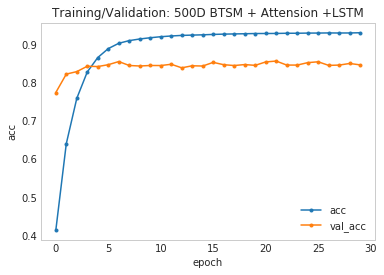

In [89]:
   
plotresult(hattenlstm, '500D BTSM + Attension +LSTM', 'm2-model_attention_applied_before_lstm.png')    

In [ ]:
sess = tf.InteractiveSession()
sess.run(f1_score(y_test, y_pred_i))


In [ ]:
callbacks=callback_()

m2b = model_attention_applied_before_lstmv()
m2b.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
m2b.summary()

hattenlstm=m2b.fit([X], y_train, epochs=30, batch_size=64, validation_split=0.2, callbacks=[callbacks])
hattenlstm=m2b.fit([X], y_train, epochs=30, batch_size=64, validation_split=0.2, callbacks=[callbacks])

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 9, 500)       0                                            
__________________________________________________________________________________________________
permute_13 (Permute)            (None, 500, 9)       0           input_13[0][0]                   
__________________________________________________________________________________________________
reshape_13 (Reshape)            (None, 500, 9)       0           permute_13[0][0]                 
__________________________________________________________________________________________________
dense_35 (Dense)                (None, 500, 9)       90          reshape_13[0][0]                 
__________________________________________________________________________________________________
attention_

In [119]:
y_p = m2b.predict(Xtest)

####obtain PT
y_pred = [decoder[i] for i in y_p.argmax(axis=1)]
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test.tolist(), y_pred)
#obtain indices
y_pred_i=np.array([[encoder[i]] for i in y_pred])
from sklearn.metrics import classification_report,precision_recall_fscore_support

print(classification_report(np.array(Y_test), np.array(y_pred)))
precision_micro, recall_micro , fbeta_micro, support_micro=precision_recall_fscore_support(np.array(Y_test), np.array(y_pred), average='micro')
precision_macro, recall_macro , fbeta_macro, support_macro=precision_recall_fscore_support(np.array(Y_test), np.array(y_pred), average='macro')
precision_w, recall_w , fbeta_w, support_w=precision_recall_fscore_support(np.array(Y_test), np.array(y_pred), average='weighted')
print ('Micro precision/recall/F1:', precision_micro,'/', recall_micro,'/',fbeta_micro)
print ('Macro precision/recall/F1:',       precision_macro, recall_macro,'/',fbeta_macro)
print ('Weighted precision/recall/F1:','/',       precision_w,'/', recall_w,'/',fbeta_w)

                                           precision    recall  f1-score   support

                          acute psychosis       1.00      1.00      1.00         1
                                agitation       1.00      1.00      1.00         4
                                akathisia       1.00      1.00      1.00         1
       alanine aminotransferase increased       1.00      1.00      1.00         3
                                  anaemia       1.00      1.00      1.00         1
                          angina pectoris       1.00      1.00      1.00         1
                            anisometropia       0.00      0.00      0.00         1
                                 anorexia       0.00      0.00      0.00         0
                     antisocial behaviour       0.00      0.00      0.00         0
                                  anxiety       1.00      1.00      1.00        39
                           arthropod bite       1.00      1.00      1.00         1
   

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [48]:
def model_conv_sm():
    inputs = Input(shape=(WINDOWS_Size, INPUT_DIM,))
    attention_mul = attention_3d_block(inputs)
    conv_0 = Conv1D(64, 3,activation='relu',kernel_regularizer=regularizers.l2(0.01))(attention_mul)
    conv_1 = Conv1D(64, 5,activation='relu',kernel_regularizer=regularizers.l2(0.01))(attention_mul)
    conv_2 = Conv1D(64, 7,activation='relu',kernel_regularizer=regularizers.l2(0.01))(attention_mul)

    maxpool_0 = MaxPooling1D(pool_size=3)(conv_0)
    maxpool_1 = MaxPooling1D(pool_size=3)(conv_1)
    maxpool_2 = MaxPooling1D(pool_size=3)(conv_2)

    merged_tensor = concatenate([maxpool_0, maxpool_1,maxpool_2], axis=1)
    lstm_out = Bidirectional(LSTM(256, activation='tanh',recurrent_regularizer=regularizers.l2(0.01),return_sequences=True))(maxpool_0)
    merged_tensor = Flatten()(lstm_out)
    dnn_out=Dense(64, activation=tf.nn.relu)(merged_tensor)
    output = Dense(CLASSES, activation='softmax')(merged_tensor)
    model = Model(input=[inputs], output=output)
    return model

## convolv

In [51]:
K.clear_session()

#embedding_layer(100)

dir_path = 'output'
tensor_path = 'output/log_dir'
os.makedirs(tensor_path)

In [53]:
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
#ckpt_save = os.path.join(dir_path, 'BTWS100D+atten+pconv.hdf5')
#checkpoint = ModelCheckpoint(ckpt_save, monitor='val_loss', verbose=1, save_best_only=True)
#tensorboard = TensorBoard(log_dir=dir_path, histogram_freq=2000, write_graph=True, write_images=False)
callback_list = [early_stop, tensorboard]

m3 = model_conv_sm()
m3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
m3.summary()

hm3=m3.fit([X], y_train, epochs=30, batch_size=32, validation_split=0.2, callbacks=[early_stop])

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 9, 100)       0                                            
__________________________________________________________________________________________________
permute_2 (Permute)             (None, 100, 9)       0           input_2[0][0]                    
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 100, 9)       0           permute_2[0][0]                  
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 100, 9)       90          reshape_2[0][0]                  
__________________________________________________________________________________________________
attention_

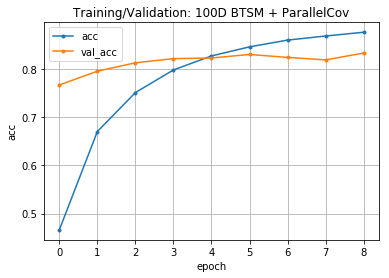

Saved model to disk


In [59]:
file='m3-atten+parallel_conv+lstm'
plotresult(hm3, '100D BTSM + ParallelCov', file+'.png') 
# serialize model to JSON
model_json = m3.to_json()
with open('models/100d/'+file+'.json', 'w') as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
m3.save_weights('models/100d/'+file+'.h5')
print("Saved model to disk")
 

In [55]:
score = m3.evaluate(Xtest, y_test, verbose=0)
print("loss/acc:", score)

loss/acc: [0.6097356141477391, 0.9347826069679813]


In [56]:
score = m3.evaluate(Xtest, y_test, verbose=0)
print("loss/acc:", score)
y_p = m3.predict(Xtest)

####obtain PT
y_pred = [decoder[i] for i in y_p.argmax(axis=1)]
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test.tolist(), y_pred)
#obtain indices
y_pred_i=np.array([[encoder[i]] for i in y_pred])
from sklearn.metrics import classification_report,precision_recall_fscore_support

print(classification_report(np.array(Y_test), np.array(y_pred)))
precision_micro, recall_micro , fbeta_micro, support_micro=precision_recall_fscore_support(np.array(Y_test), np.array(y_pred), average='micro')
precision_macro, recall_macro , fbeta_macro, support_macro=precision_recall_fscore_support(np.array(Y_test), np.array(y_pred), average='macro')
precision_w, recall_w , fbeta_w, support_w=precision_recall_fscore_support(np.array(Y_test), np.array(y_pred), average='weighted')
print ('Micro precision/recall/F1:', precision_micro,'/', recall_micro,'/',fbeta_micro)
print ('Macro precision/recall/F1:',       precision_macro, recall_macro,'/',fbeta_macro)
print ('Weighted precision/recall/F1:','/',       precision_w,'/', recall_w,'/',fbeta_w)

                                           precision    recall  f1-score   support

                          acute psychosis       1.00      1.00      1.00         1
                                agitation       1.00      1.00      1.00         4
                                akathisia       1.00      1.00      1.00         1
       alanine aminotransferase increased       1.00      1.00      1.00         3
                                  anaemia       1.00      1.00      1.00         1
                          angina pectoris       1.00      1.00      1.00         1
                            anisometropia       1.00      1.00      1.00         1
                                  anxiety       1.00      1.00      1.00        39
                           arthropod bite       1.00      1.00      1.00         1
     aspartate aminotransferase increased       1.00      1.00      1.00         2
                                 asthenia       1.00      1.00      1.00         4
   

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## 2nd conv 

In [65]:
def model_conv_2():
    inputs = Input(shape=(WINDOWS_Size, INPUT_DIM,))
    attention_mul = attention_3d_block(inputs)
    conv_0 = Conv1D(64, 7,activation='relu',kernel_regularizer=regularizers.l2(0.01))(attention_mul)
    #conv_0=Dropout(0.2)(conv_0)
    conv_1 = Conv1D(64, 5,activation='relu',kernel_regularizer=regularizers.l2(0.01))(attention_mul)
    #conv_1=Dropout(0.2)(conv_1)
    conv_2 = Conv1D(64, 3,activation='relu',kernel_regularizer=regularizers.l2(0.01))(attention_mul)
    #conv_2=Dropout(0.2)(conv_2)
    
    maxpool_0 = MaxPooling1D(pool_size=2)(conv_0)
    maxpool_1 = MaxPooling1D(pool_size=2)(conv_1)
    maxpool_2 = MaxPooling1D(pool_size=2)(conv_2)

    conc_tensor_0 = concatenate([maxpool_0, maxpool_1], axis=1)
    conc_tensor_1 = concatenate([maxpool_1, maxpool_2], axis=1)
    conc_tensor_2 = concatenate([maxpool_0, maxpool_2], axis=1)
    
    conc_tensor_0 = Flatten()(conc_tensor_0)
    conc_tensor_1 = Flatten()(conc_tensor_1)
    conc_tensor_2 = Flatten()(conc_tensor_2)
    
    dnn_out_1=Dense(256, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(0.01))(conc_tensor_0)
    dnn_out_2=Dense(256, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(0.01))(conc_tensor_1)    
    dnn_out_3=Dense(256, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(0.01))(conc_tensor_2)    

    conc_dnn_out=concatenate([dnn_out_1, dnn_out_2,dnn_out_3], axis=1)
    dnn_out_4=Dense(128, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(0.01))(conc_dnn_out)  
    #dnn_out_5=Dense(128, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(0.01))(dnn_out_4) 
    #dnn_out_6=Dense(128, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(0.01))(dnn_out_5) 
    output = Dense(CLASSES, activation='softmax')(dnn_out_4)
    model = Model(input=[inputs], output=output)
    return model

In [ ]:
K.clear_session()
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
#ckpt_save = os.path.join(dir_path, 'BTWS100D+atten+pconv.hdf5')
#checkpoint = ModelCheckpoint(ckpt_save, monitor='val_loss', verbose=1, save_best_only=True)
#tensorboard = TensorBoard(log_dir=dir_path, histogram_freq=2000, write_graph=True, write_images=False)
callback_list = [early_stop, tensorboard]

m4 = model_conv_2()
m4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
m4.summary()

hm4=m4.fit([X], y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_stop])

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:32: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 9, 100)       0                                            
__________________________________________________________________________________________________
permute_1 (Permute)             (None, 100, 9)       0           input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 100, 9)       0           permute_1[0][0]                  
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100, 9)       90          reshape_1[0][0]                  
__________________________________________________________________________________________________
attention_

In [ ]:
file='m4-atten+parallel_conv+dense'
plotresult(hm4, '100D BTSM + ParallelCov', file+'.png') 
# serialize model to JSON
model_json = m4.to_json()
with open('models/100d/'+file+'.json', 'w') as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
m4.save_weights('models/100d/'+file+'.h5')
print("Saved model to disk")
 

In [ ]:
score = m4.evaluate(Xtest, y_test, verbose=0)
print("loss/acc:", score)
y_p = m4.predict(Xtest)

####obtain PT
y_pred = [decoder[i] for i in y_p.argmax(axis=1)]
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test.tolist(), y_pred)
#obtain indices
y_pred_i=np.array([[encoder[i]] for i in y_pred])
from sklearn.metrics import classification_report,precision_recall_fscore_support

print(classification_report(np.array(Y_test), np.array(y_pred)))
precision_micro, recall_micro , fbeta_micro, support_micro=precision_recall_fscore_support(np.array(Y_test), np.array(y_pred), average='micro')
precision_macro, recall_macro , fbeta_macro, support_macro=precision_recall_fscore_support(np.array(Y_test), np.array(y_pred), average='macro')
precision_w, recall_w , fbeta_w, support_w=precision_recall_fscore_support(np.array(Y_test), np.array(y_pred), average='weighted')
print ('Micro precision/recall/F1:', precision_micro,'/', recall_micro,'/',fbeta_micro)
print ('Macro precision/recall/F1:',       precision_macro, recall_macro,'/',fbeta_macro)
print ('Weighted precision/recall/F1:','/',       precision_w,'/', recall_w,'/',fbeta_w)

#### Save model

In [ ]:
# serialize model to JSON
model_json = m.to_json()
with open("models/500d/model+biLSTM+dense+atten+500D.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
m.save_weights("models/500d/model+biLSTM+dense+atten+500D.h5")
print("Saved model to disk")
 

In [ ]:
# later...
 
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 

In [ ]:
attention_vectors = []
for i in range(100):
    
    attention_vector = np.mean(get_activations(m,
                                               Xtest,
                                               print_shape_only=True,
                                               layer_name='attention_vec')[0], axis=2).squeeze()
    print('attention =', attention_vector)
    #assert (np.sum(attention_vector) - 1.0) < 1e-5
    attention_vectors.append(attention_vector)

attention_vector_final = np.mean(np.array(attention_vectors), axis=0)

In [ ]:
attention_vector_final

In [ ]:
pd.DataFrame(data=attention_vector_final[1:,1:],   
              index=attention_vector_final[1:,0],    
              columns=attention_vector_final[0,1:]).plot(kind='bar',
                                                                     title='Attention Mechanism as '
                                                                           'a function of input'
                                                                           ' dimensions.')
plt.show()

In [ ]:
# plot part.
import matplotlib.pyplot as plt
import pandas as pd

pd.DataFrame(attention_vector_final, columns=['attention (%)']).plot(kind='bar',
                                                                     title='Attention Mechanism as '
                                                                           'a function of input'
                                                                           ' dimensions.')
plt.show()